# **Project: Image Colorization**


---



# Introduction:
When choosing a project, we wanted a problem that was not only a classic deep learning challenge but also visually impressive and requires a bit of creative thinking. Image colorization was the perfect fit.

 On our journey, we discovered that it's quite challenging but still very fascinating problem.

* A single grayscale image can have multiple plausible colorizations. This forces the model to go beyond simple mapping and develop a genuine semantic understanding of the image content. It needs to learn that skies are usually blue and grass is usually green, but also understand context, lighting, and texture. (This is a key point we'll return to.)


*  This project allowed us to implement and experiment with architectures like U-Net and GANs, which are ideal for image-to-image tasks. We got hands-on experience with concepts like skip-connections, transfer learning, and working with massive datasets. However we also faced some hardhips we couldn't resolve so easily, such as the constant struggle to balance the generator and discriminator. But more on that later.

In the following section, we'll take notice of some important concepts to grasp that were essential for our project.



# LAB Color space

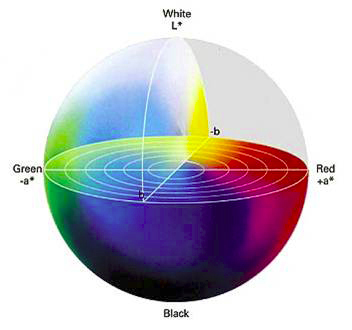



**Why LAB?**

At first glance, it might seem logical to use the standard RGB (Red, Green, Blue) color space. After all, it's how our screens display images. However, for a deep learning model learning to colorize, RGB presents several major problems. The L*a*b* color space is used because it directly solves these problems by reframing the task into something much more logical and easier for a network to learn.

**The Problem with RGB**

The RGB model defines a color by mixing three channels: Red, Green, and Blue. The core issue is that lightness (brightness) and color (chroma) are entangled.

A neural network trying to colorize a grayscale image using RGB would have to:

* Take a single grayscale value (e.g., 128).

* Predict three separate values (R, G, and B) that are highly correlated with each other and with the input brightness.

This is an unnecessarily complex task. The model has to learn both what color something should be and how bright that color should be, even though the brightness information is already present in the original grayscale image.

**The L*a*b* Solution**

The L*a*b* color space was designed specifically to align with human perception. It decouples brightness from color, which is the key to its power. It consists of three channels:

L* (Lightness): This is the grayscale component. It represents the brightness of a pixel, ranging from 0 (pure black) to 100 (pure white). This channel is almost identical to our input grayscale image.

a* (Green-Red Axis): This channel represents the color on a spectrum from green (negative values) to red (positive values).

b* (Blue-Yellow Axis): This channel represents the color on a spectrum from blue (negative values) to yellow (positive values).
**The Key Advantages for Deep Learning**

By converting the problem to L*a*b*, we change the entire goal of the neural network.

The network no longer has to "re-learn" the brightness of each pixel; it's provided as the input. The model can focus entirely on the true task: associating specific colors with the shapes, textures, and contexts it sees in the grayscale L* channel. This is a much cleaner, more well-defined regression problem.
When using L*a*b*, L2 distance (mean squared error - Euclidian distance) is perceptually meaningful. A small error between the predicted (a*, b*) and the true (a*, b*) means the predicted color is visually close to the real color. In RGB, minimizing the L2 distance can lead to the model producing desaturated, muddy colors because it's a "safer" mathematical average that doesn't correspond well to visual reality.




**For now, this is enough of an introduction, and we will elaborate on our steps  further as we go on. First we need to import and load our dataset.**

### We begin by loading the data, but since the process isn't crucial to understand, we'll start by showing the data exploration instead.

# Data exploration

At the end of this section, we provided useful insights and observations that helped us make key decisions regarding the project.

### Shape:

In [5]:
# Load grayscale image data (L channel)
import numpy as np
gray_images = np.load('image_colorization_data/l/gray_scale.npy')

# Load AB color channels
ab1 = np.load('image_colorization_data/ab/ab/ab1.npy')
ab2 = np.load('image_colorization_data/ab/ab/ab2.npy')
ab3 = np.load('image_colorization_data/ab/ab/ab3.npy')

In [6]:
print("Gray scale shape:", gray_images.shape)
print("AB1 shape:", ab1.shape)
print("AB2 shape:", ab2.shape)
print("AB3 shape:", ab3.shape) #printing the shapes of all channels

Gray scale shape: (25000, 224, 224)
AB1 shape: (10000, 224, 224, 2)
AB2 shape: (10000, 224, 224, 2)
AB3 shape: (5000, 224, 224, 2)


In [7]:
print("L Channel Range:", gray_images.min(), "to", gray_images.max())
print("AB Channels Range:", ab1.min(), "to", ab1.max())

L Channel Range: 0 to 255
AB Channels Range: 20 to 226


### Loading one picture and printing it's grayscale, LAB and colorized version

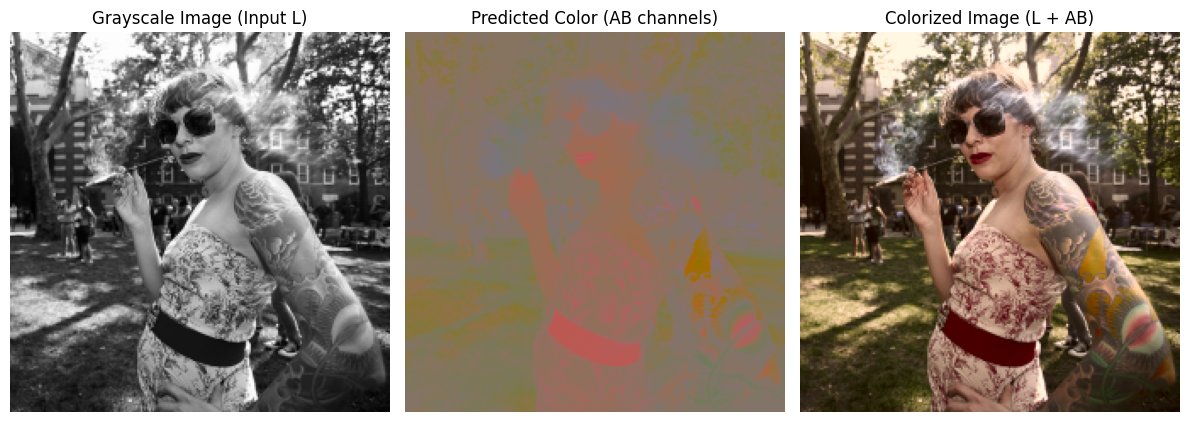

In [8]:
import cv2
import matplotlib.pyplot as plt
index = 0 # Using the first image for this example

# Selecting the corresponding AB image from the correct file based on index
if index < ab1.shape[0]:
    ab = ab1[index]
elif index < ab1.shape[0] + ab2.shape[0]:
    ab = ab2[index - ab1.shape[0]]
else:
    ab = ab3[index - ab1.shape[0] - ab2.shape[0]]
# Getting corresponding grayscale image and scale it from [0,255] → [0,100] (L* range in LAB)
l_channel_orig = gray_images[index]
l_channel = (l_channel_orig.astype(float) / 255.0) * 100   #In LAB color space, L values range from 0 to 100

# OpenCV expects a* and b* channels in the range [-128, 127]
# This transformation is specific to how the data was saved.
ab_scaled = ((ab.astype(float) - 20) / (226 - 20)) * 255 - 128

# Combine L and AB channels into a single LAB image
lab_image = np.dstack((l_channel, ab_scaled))

# Converting the full LAB image to RGB
colorized_image = cv2.cvtColor(lab_image.astype(np.float32), cv2.COLOR_LAB2RGB)
colorized_image = np.clip(colorized_image, 0, 1)


# To visualize just the color (a* and b* channels), we create a new LAB image
# with a constant lightness (L=50 is neutral gray) and our predicted AB channels.
constant_l_channel = np.full_like(l_channel, 50) # Create an L-channel of all 50s
ab_color_visualization_lab = np.dstack((constant_l_channel, ab_scaled))

# Now, converting this new LAB image to RGB to see the pure colors
ab_color_visualization_rgb = cv2.cvtColor(ab_color_visualization_lab.astype(np.float32), cv2.COLOR_LAB2RGB)
ab_color_visualization_rgb = np.clip(ab_color_visualization_rgb, 0, 1)

# --- Plotting the results ---
fig, ax = plt.subplots(1, 3, figsize=(12, 5))

# Panel 1: Original Grayscale Image
ax[0].imshow(l_channel_orig, cmap='gray')
ax[0].set_title("Grayscale Image (Input L)")
ax[0].axis("off")

# Panel 2: Visualization of the AB Channels ("LAB Image")
ax[1].imshow(ab_color_visualization_rgb)
ax[1].set_title("Predicted Color (AB channels)")
ax[1].axis("off")

# Panel 3: Final Colorized Image
ax[2].imshow(colorized_image)
ax[2].set_title("Colorized Image (L + AB)")
ax[2].axis("off")

plt.tight_layout()
plt.show()

In the LAB color space:

L: Lightness (0 to 100)

A: Green–Red (typically ranges from -128 to +127)

B: Blue–Yellow (typically ranges from -128 to +127)

### Brightness Distribution Across Dataset

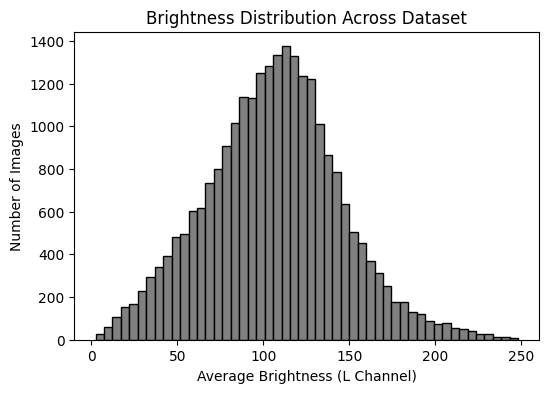

In [ ]:
# Compute brightness levels
avg_brightness = np.mean(gray_images, axis=(1, 2))

# Plot brightness distribution
plt.figure(figsize=(6, 4))
plt.hist(avg_brightness, bins=50, color="gray", edgecolor="black")
plt.xlabel("Average Brightness (L Channel)")
plt.ylabel("Number of Images")
plt.title("Brightness Distribution Across Dataset")
plt.show()

### Colorfulness distribution

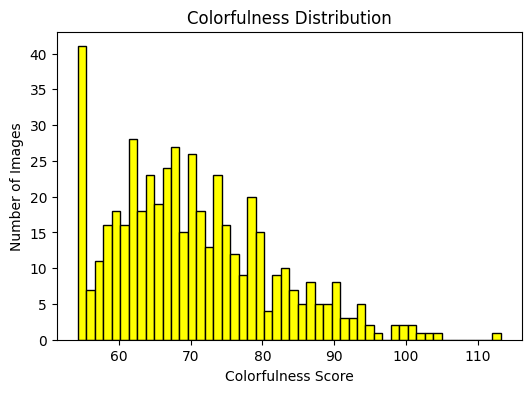

In [ ]:
def compute_colorfulness(a, b):
    """Computes a simple colorfulness metric based on AB channels."""
    mean_a, mean_b = np.mean(a), np.mean(b)
    std_a, std_b = np.std(a), np.std(b)
    return np.sqrt(std_a**2 + std_b**2) + 0.3 * np.sqrt(mean_a**2 + mean_b**2)
random_indices = np.random.choice(ab1.shape[0], 500, replace=False)
colorfulness_scores = [compute_colorfulness(ab1[i, :, :, 0], ab1[i, :, :, 1]) for i in random_indices]
# Plot colorfulness distribution
plt.figure(figsize=(6, 4))
plt.hist(colorfulness_scores, bins=50, color="yellow", edgecolor="black")
plt.xlabel("Colorfulness Score")
plt.ylabel("Number of Images")
plt.title("Colorfulness Distribution")
plt.show()

* How much the colors vary (standard deviation)
* How far the colors are from neutral gray (mean)<br>
Higher values = more variety of colors

### LAB channels distribution

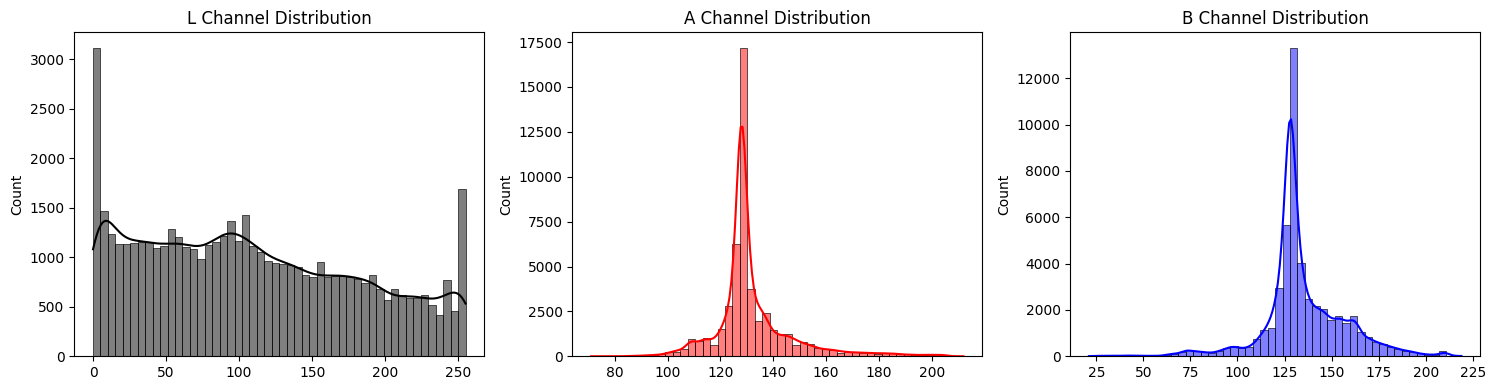

In [ ]:
import seaborn as sns

# Load a subset of the data (e.g., first 50 images)
l_channel = np.load("image_colorization_data/l/gray_scale.npy")[:50]  # adjust this number
ab1 = np.load("image_colorization_data/ab/ab/ab1.npy")[:50]

# Flatten to pixels
l_pixels = l_channel.reshape(-1)
ab_pixels = ab1.reshape(-1, 2)

# Sample a fixed number of pixels
sample_size = 50000  # smaller number
indices = np.random.choice(len(l_pixels), sample_size, replace=False)

l_values = l_pixels[indices]
ab_sample = ab_pixels[indices]

# Split AB
a_values = ab_sample[:, 0]
b_values = ab_sample[:, 1]

# Plot
fig, ax = plt.subplots(1, 3, figsize=(15, 4))
sns.histplot(l_values, bins=50, kde=True, ax=ax[0], color="black")
ax[0].set_title("L Channel Distribution")

sns.histplot(a_values, bins=50, kde=True, ax=ax[1], color="red")
ax[1].set_title("A Channel Distribution")

sns.histplot(b_values, bins=50, kde=True, ax=ax[2], color="blue")
ax[2].set_title("B Channel Distribution")

plt.tight_layout()
plt.show()


### K-Means Clustering of AB Colors

Centroids (scaled): [[1.00380892 0.99511651]
 [0.97640035 1.44118514]
 [1.27628477 1.25394735]
 [0.97409206 1.18808501]
 [1.15434914 0.66267331]]


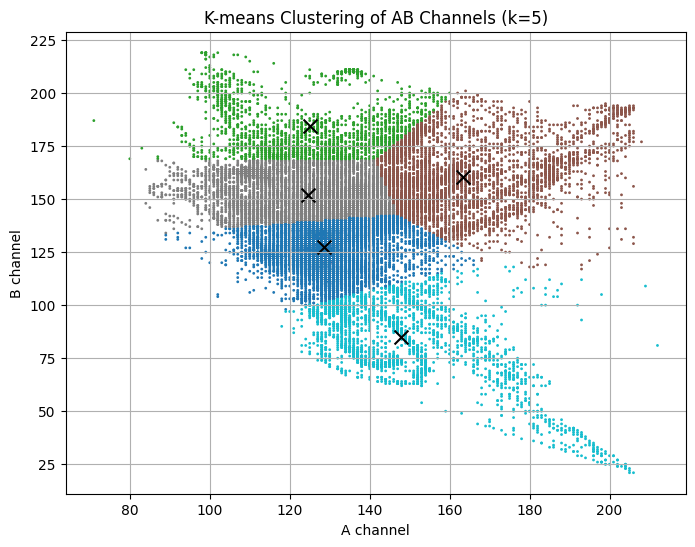

In [ ]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

ab_scaled = ab_sample / 128.0  # Scale to roughly [-1, 1] range

# Choose number of clusters
k = 5
kmeans = KMeans(n_clusters=k, random_state=42)
labels = kmeans.fit_predict(ab_scaled)
centroids = kmeans.cluster_centers_ #centroid is the average (mean) position of all the points in a cluster

print("Centroids (scaled):", centroids)
plt.figure(figsize=(8, 6))
plt.scatter(ab_sample[:, 0], ab_sample[:, 1], c=labels, cmap='tab10', s=1)
plt.scatter(centroids[:, 0] * 128, centroids[:, 1] * 128, color='black', marker='x', s=100)
plt.xlabel("A channel")
plt.ylabel("B channel")
plt.title(f"K-means Clustering of AB Channels (k={k})")
plt.grid(True)
plt.show()

# Observations after data exploration

The data exploration phase revealed several key characteristics in the dataset, which directly inform the necessary preprocessing steps for building the colorization model.

* Dataset Structure and Shape:

The data is provided in the LAB color space, separated into the L channel (grayscale) and the AB channels (color).

The total number of AB images (10,000 + 10,000 + 5,000 = 25,000) perfectly matches the number of grayscale images in the L channel file (gray_scale.npy). This confirms the dataset is complete, but the color information is fragmented.

**Decision for this project:** Due to computational constraints in the Google Colab environment, the initial model will be trained on a subset of the data. We will use the first 10,000 grayscale images and the corresponding 10,000 color images from ab1.npy. This avoids the overhead of loading and concatenating all 25,000 images at once.

* Color Space and Value Ranges:

The histograms of the A and B channels show that the pixel values are not centered around 0 but rather around a mean of ~120-130. This indicates a non-standard range for the color channels, which will require normalization. The code in cell [9] correctly identifies a custom scaling from a [20, 226]-like range to the standard [-128, 127] range for LAB.
Brightness (L-channel) Distribution:
The histogram of average brightness across the dataset is widely distributed, with many images having very low (<50) or very high (>170) average brightness values.
This suggests the presence of a significant number of over-exposed and under-exposed images. These images might not provide useful color information and could make training less stable.



* Colorfulness (AB-channels) Distribution:

The colorfulness score distribution is heavily right-skewed, meaning that a large portion of the images in the dataset has low to moderate colorfulness.

A small number of images are very vibrant and colorful. This observation justifies filtering out images with very low colorfulness to focus the model on learning meaningful colorization rather than reproducing near-grayscale images.

* Dominant Color Palettes:

K-Means clustering on the AB color channels shows that the colors are not randomly distributed. Instead, they group into a few distinct clusters.
This indicates the presence of dominant color palettes (e.g., earthy tones, blues, greens) within the dataset, which is a useful pattern for a colorization model to learn.



---


These observations highlight the need for several preprocessing steps before training:

Subsetting: Reduce the L-channel data to 10,000 images to match the ab1.npy file.
Resizing: Downsample images from 224x224 to a smaller size (like 128x128) to manage memory and computational load.

Filtering: Remove outlier images based on brightness and colorfulness to create a cleaner, more focused training set.

Normalization: Scale the L and AB channels to a consistent range (e.g., [-1, 1]) suitable for a GAN architecture with a tanh activation function in the generator.